In [1]:
# Updated Dataset Visualization Notebook for MARBLE Project
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
import os
import random
from glob import glob
from typing import Dict, List, Tuple, Optional
import datetime
import traceback

# Import dataset classes from dataset_constructor
from datasets import RawDataset, BandpowerDataset, EventSegmentDataset

In [4]:
# Set display parameters
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

# Find the latest datasets
def find_latest_datasets(datasets_dir='./Datasets'):
    """Find the latest datasets of each type"""
    raw_files = sorted(glob(os.path.join(datasets_dir, '*raw_dataset.npz')))
    bp_files = sorted(glob(os.path.join(datasets_dir, '*bandpower_dataset.npz')))
    event_files = sorted(glob(os.path.join(datasets_dir, '*event_segments_dataset.npz')))
    
    latest_raw = raw_files[-1] if raw_files else None
    latest_bp = bp_files[-1] if bp_files else None
    latest_event = event_files[-1] if event_files else None
    
    return latest_raw, latest_bp, latest_event

# Load the latest datasets
latest_raw, latest_bp, latest_event = find_latest_datasets()
print(f"Latest raw dataset: {os.path.basename(latest_raw) if latest_raw else 'None'}")
print(f"Latest bandpower dataset: {os.path.basename(latest_bp) if latest_bp else 'None'}")
print(f"Latest event segment dataset: {os.path.basename(latest_event) if latest_event else 'None'}")


Latest raw dataset: 20250419_130924_raw_dataset.npz
Latest bandpower dataset: 20250419_130924_bandpower_dataset.npz
Latest event segment dataset: 20250419_130924_event_segments_dataset.npz


In [14]:
data_list, time_list, events_list = raw_dataset.get_batched_data(
    start_idx=0, 
    num_chunks=25,  # Get more chunks for a batch example
    batch_size=5,
    chunks_per_batch_item=5
)


Raw Dataset:
Number of chunks: 3267
Sampling frequency: 50 Hz
Number of batches: 5
Batch item shape: (6, 50000)
Time array shape: (50000,)
Events array shape: (50000,)
Visualizing 6 channels


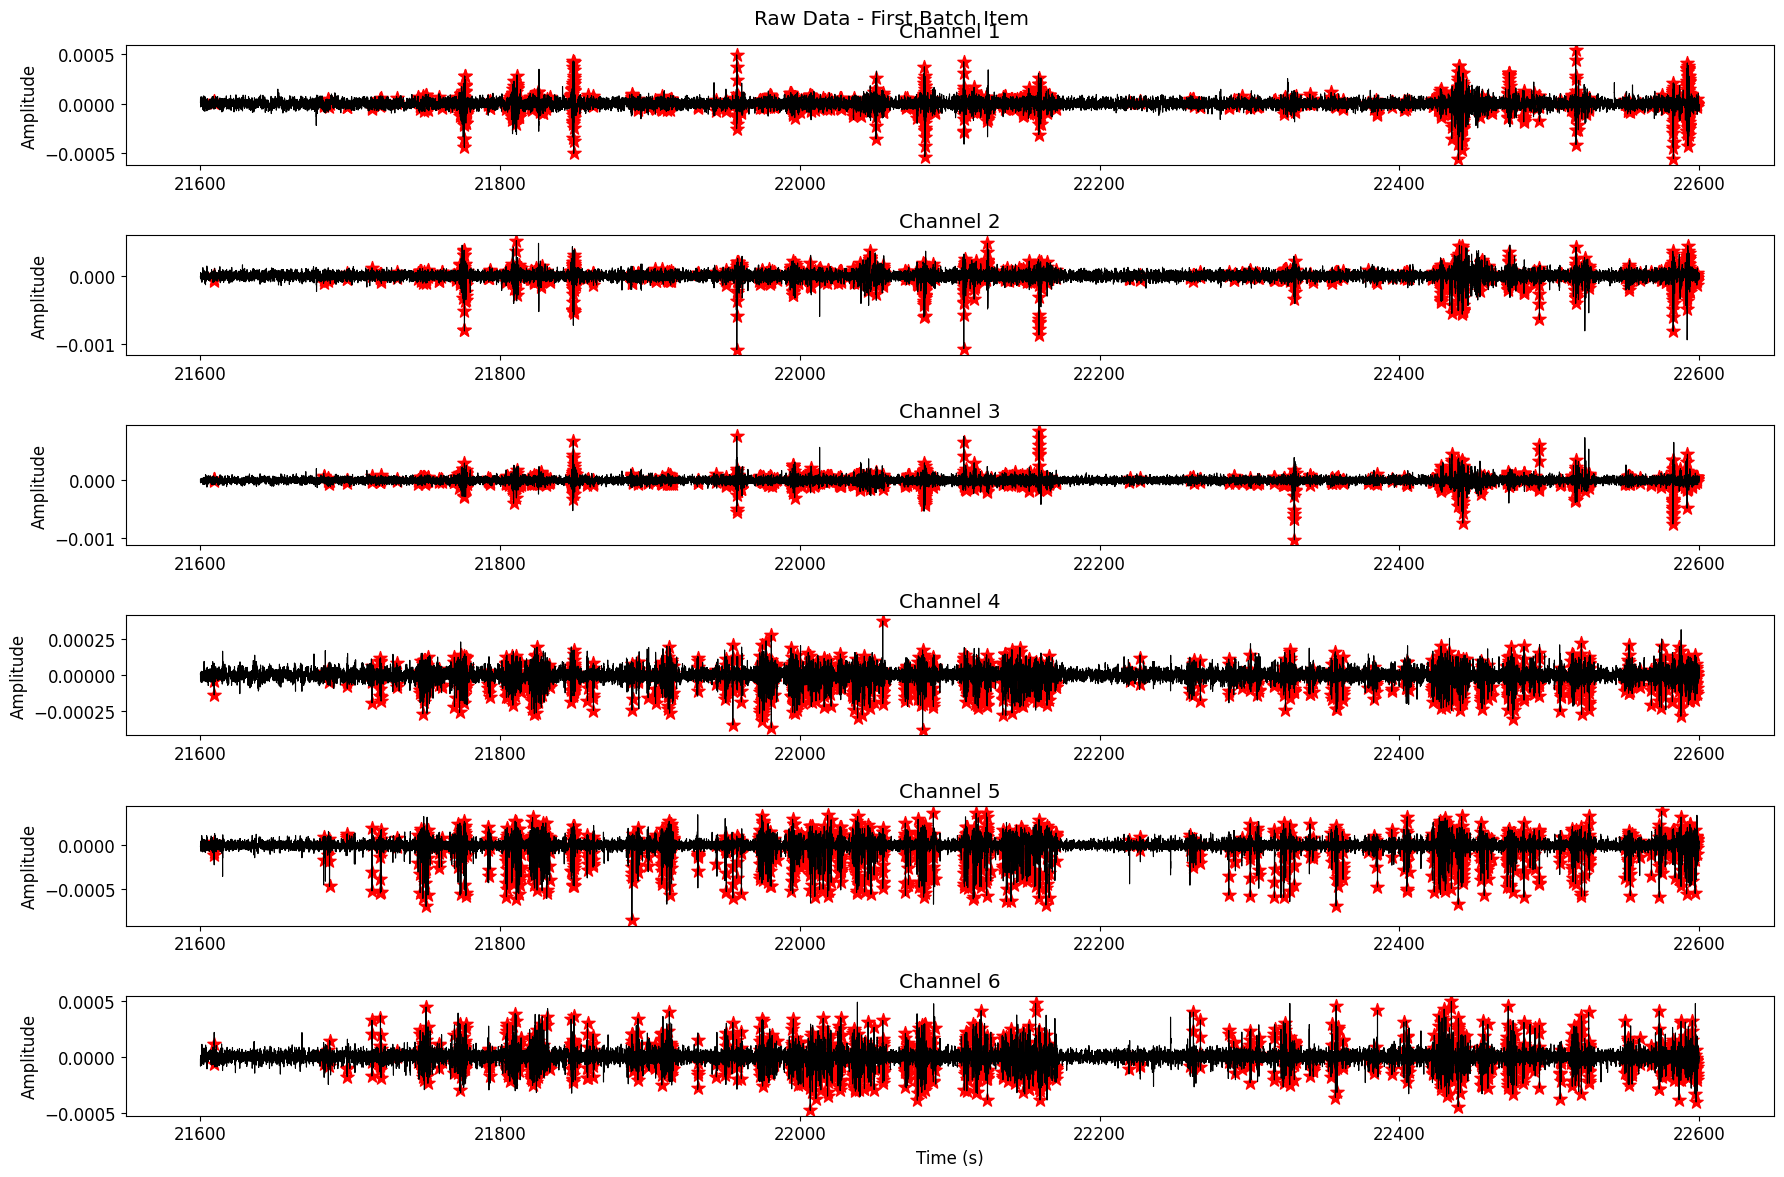

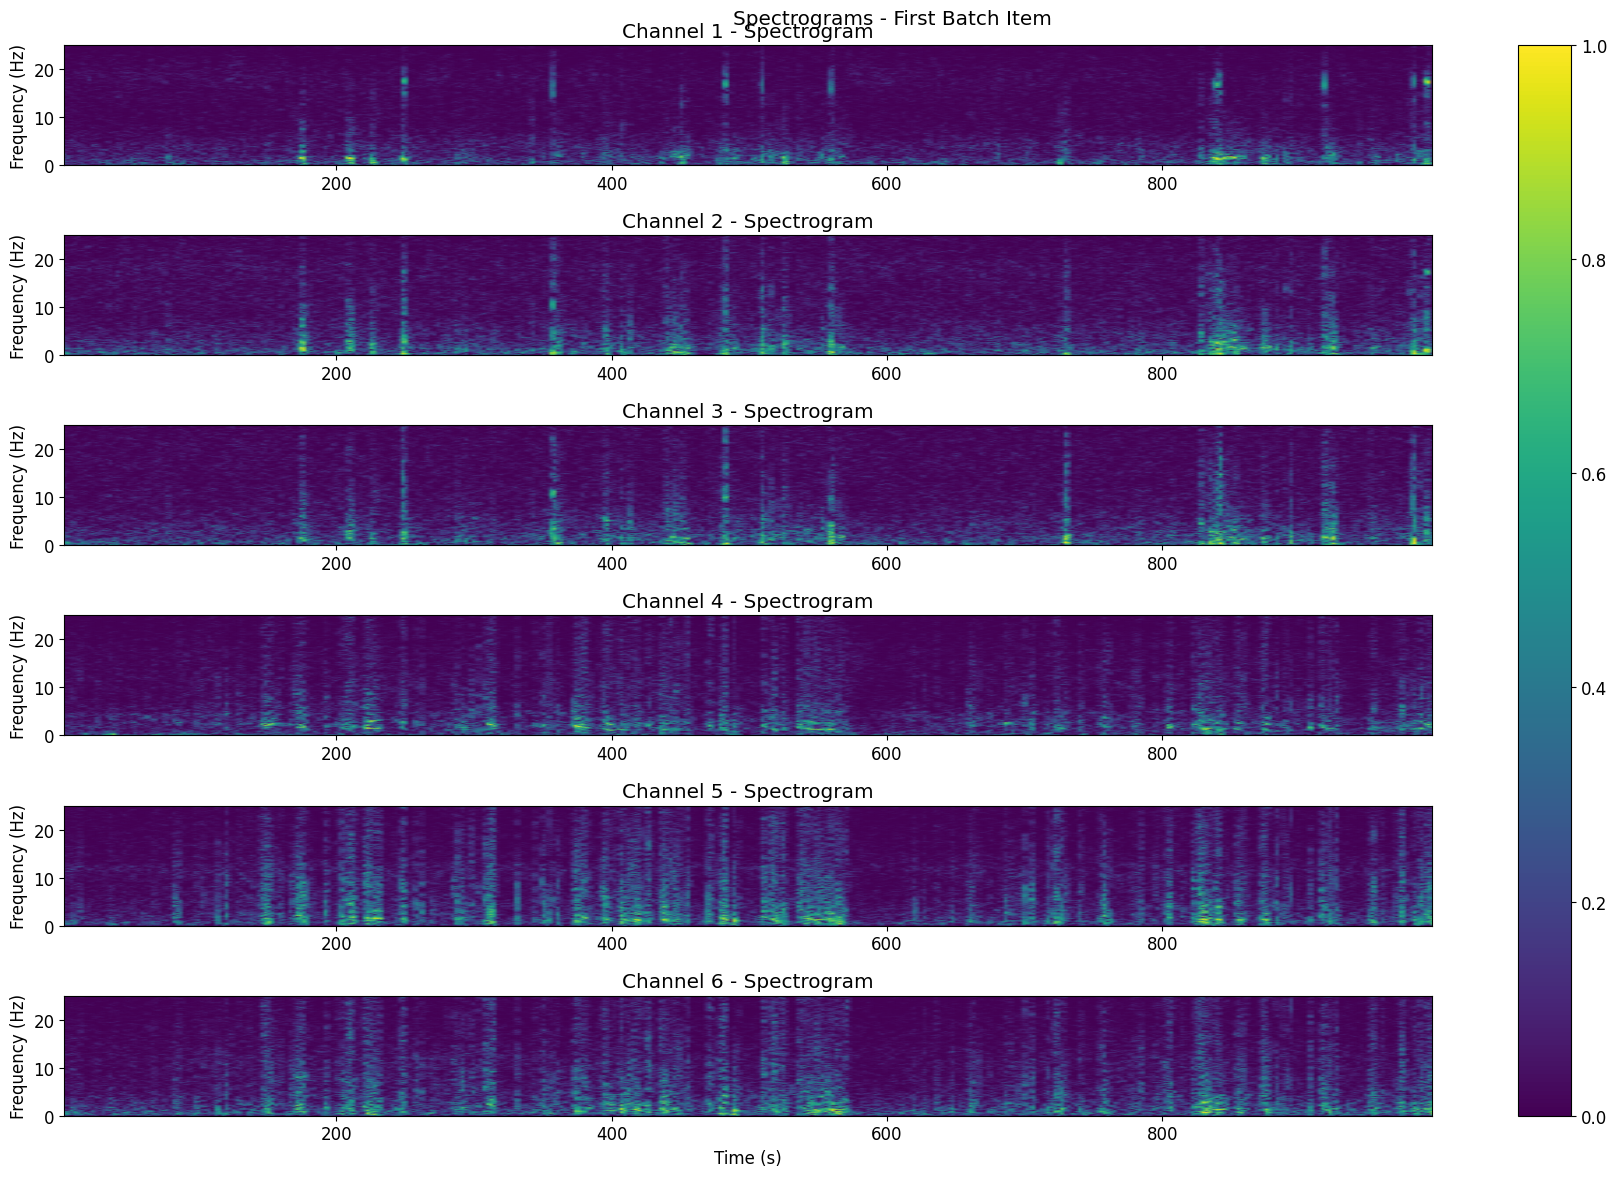


Bandpower Dataset:
Number of chunks: 3267
Dataset attributes: ['band_definitions', 'bands', 'config', 'day_night_labels', 'event_labels', 'file_indices', 'metadata', 'night_end_hour', 'night_start_hour', 'time_arrays']
Available bands: ['gamma', 'high_gamma']
Band gamma - Number of batches: 5
Band data shape for gamma: (19995, 6)
Visualizing 6 channels for gamma band


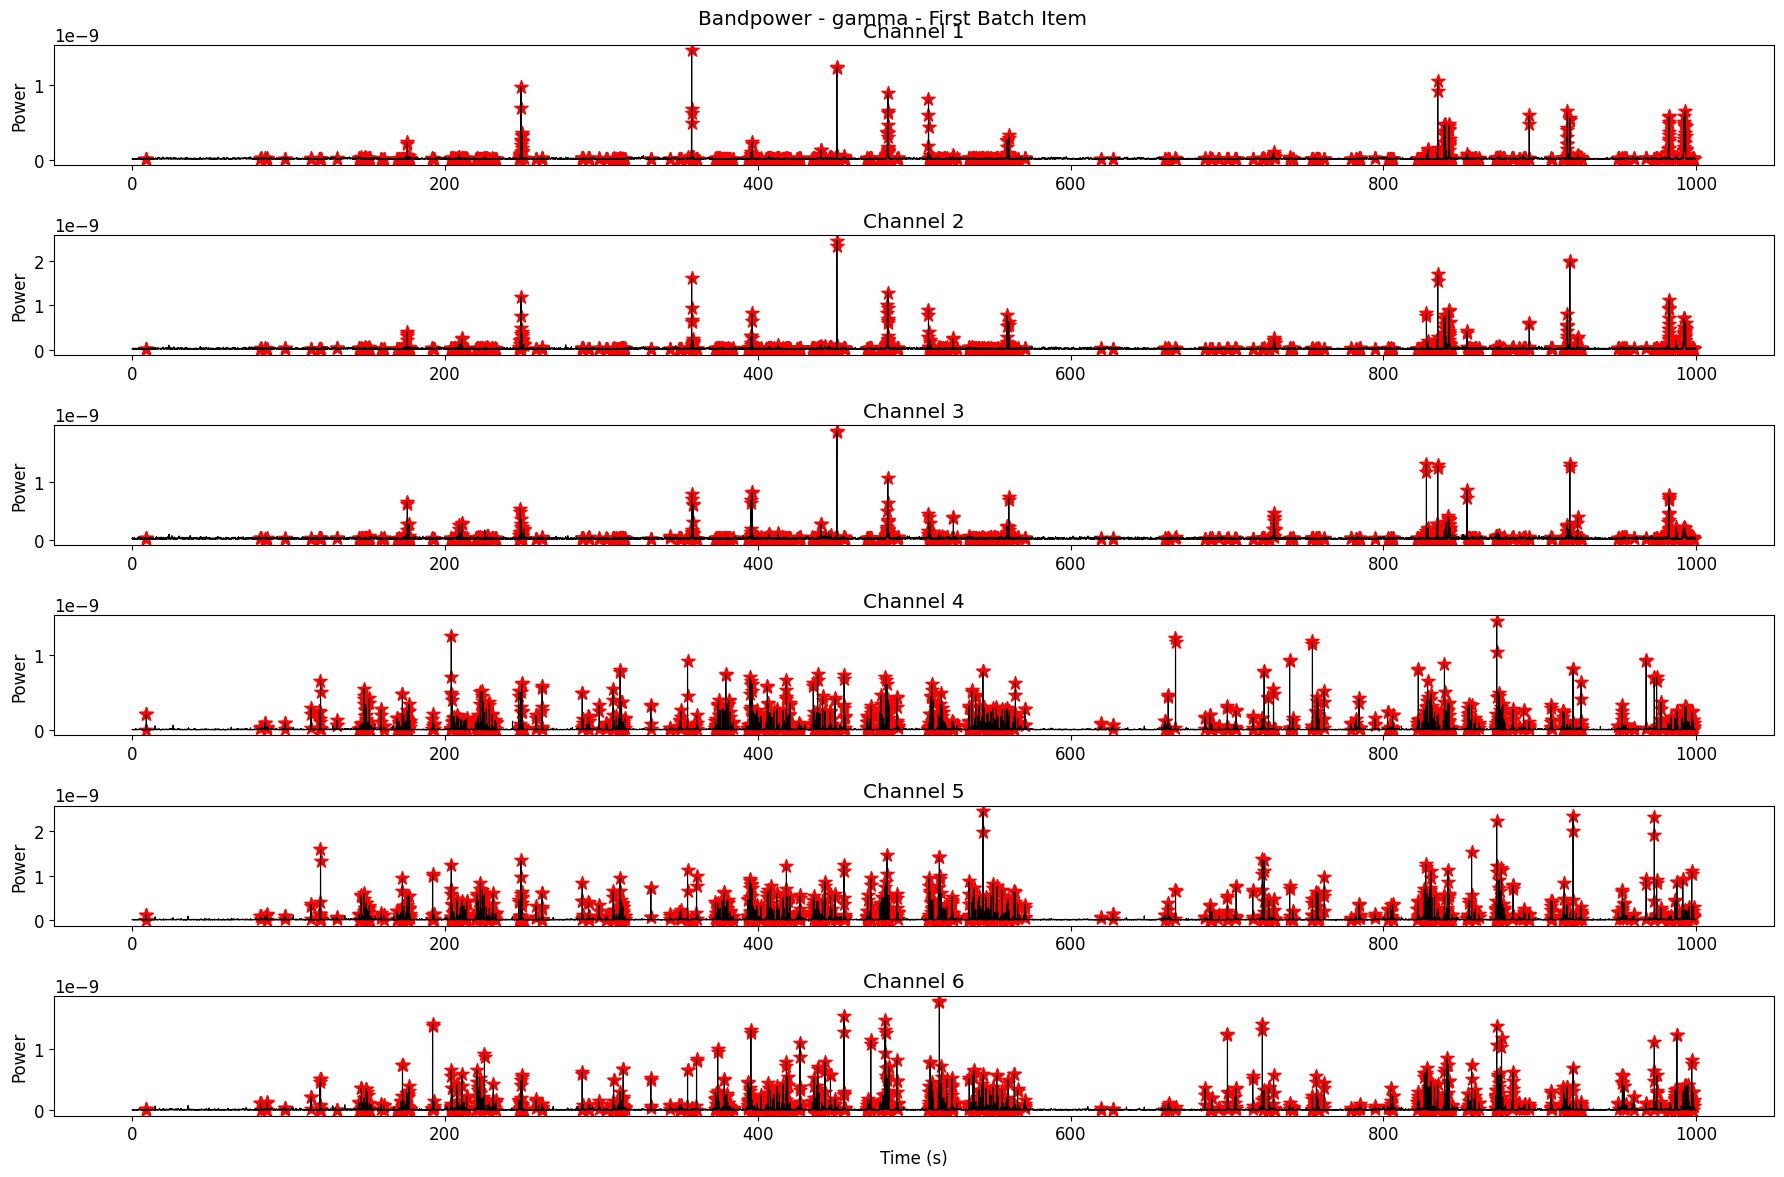

Successfully visualized gamma band data
Band high_gamma - Number of batches: 5
Band data shape for high_gamma: (19995, 6)
Visualizing 6 channels for high_gamma band


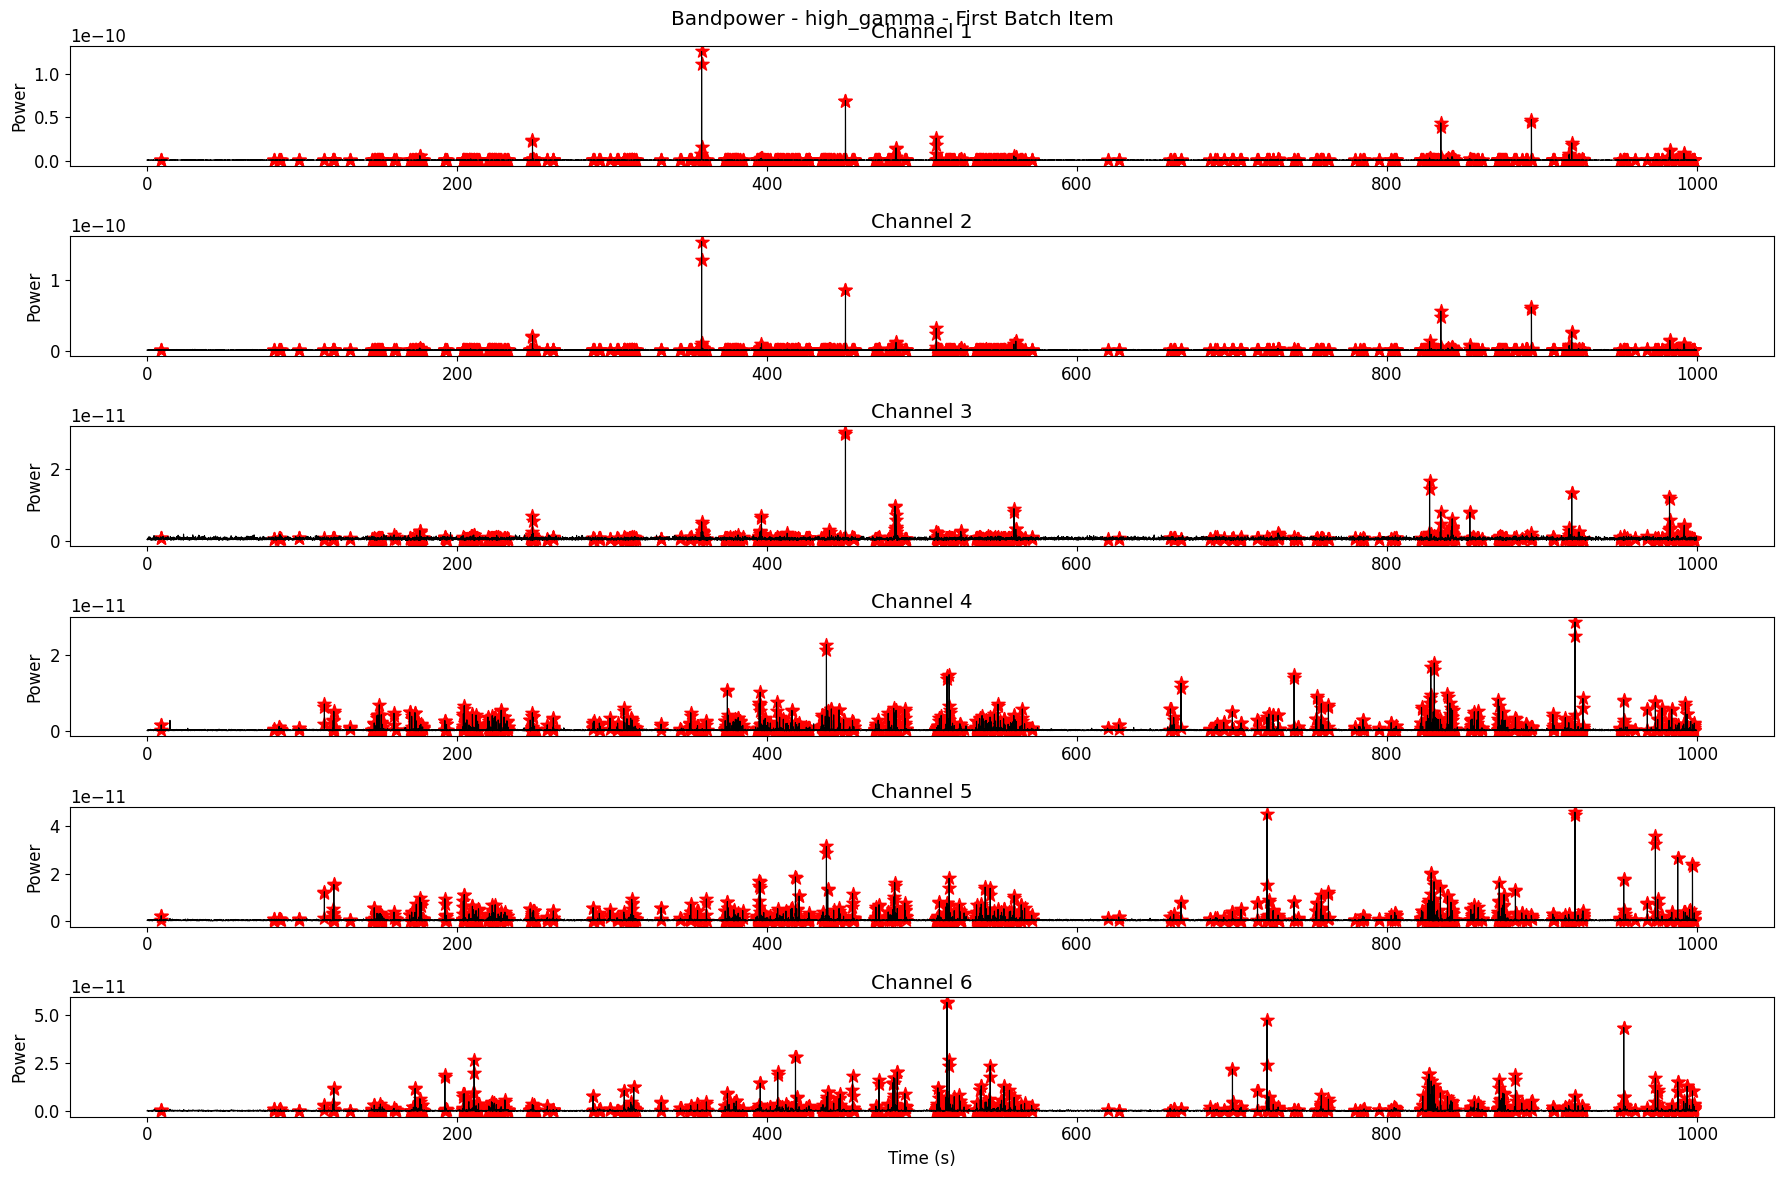

Successfully visualized high_gamma band data

Event Segment Dataset:
Number of segments: 160613
Dataset attributes: ['config', 'data', 'day_night_labels', 'event_labels', 'event_sources', 'high_band', 'low_band', 'metadata', 'night_end_hour', 'night_start_hour', 'post_event_ms', 'pre_event_ms', 'rel_time_arrays', 'segment_params', 'time_arrays']
Metadata keys: ['creation_date', 'config', 'dataset_type', 'pre_event_ms', 'post_event_ms', 'event_detection', 'day_night_params', 'used_files', 'segment_info']
Event detection bands: Low=[80, 250], High=[250, 400]
Number of segments in metadata: 160613
Event type counts from metadata: {1: 0, 2: 0, 3: 0}
Event dataset - Number of batches: 5
Batch item shape: (6, 500)
Time array shape: (500,)
Events array shape: (500,)

Segment 1 shape: (500,)


TypeError: 'float' object is not subscriptable

In [5]:
# 1. Raw Dataset Visualization
# ==========================
# Load dataset using the RawDataset class
raw_dataset = RawDataset.load(latest_raw)

# Print dataset information
print("\nRaw Dataset:")
print(f"Number of chunks: {len(raw_dataset)}")

# Get sampling frequency
sfreq = raw_dataset.config.get('raw_dataset', {}).get('resample_freq', 1000)
print(f"Sampling frequency: {sfreq} Hz")

# Get a chunk of data - now returns lists
data_list, time_list, events_list = raw_dataset.get_batched_data(
    start_idx=0, 
    num_chunks=25,  # Get more chunks for a batch example
    batch_size=5,
    chunks_per_batch_item=5
)

# Print shapes to understand the structure
print(f"Number of batches: {len(data_list)}")
if data_list:
    print(f"Batch item shape: {data_list[0].shape}")
    print(f"Time array shape: {time_list[0].shape}")
    print(f"Events array shape: {events_list[0].shape if events_list[0] is not None else 'None'}")

# Use the first batch item for visualization
if data_list:
    chunk_data = data_list[0]
    chunk_time = time_list[0]
    chunk_events = events_list[0]
    
    # Determine number of channels - assume the smaller dimension is channels
    if chunk_data.shape[0] < chunk_data.shape[1]:
        n_channels = chunk_data.shape[0]
        chunk_data = chunk_data.T  # Transpose to make it (time, channels)
    else:
        n_channels = chunk_data.shape[1]
        
    # Reasonable check for number of channels
    if n_channels > 100:
        print(f"Warning: Detected {n_channels} channels, which seems high. Using first 6 channels for visualization.")
        n_channels = min(6, chunk_data.shape[1])
        
    print(f"Visualizing {n_channels} channels")

    chunk_time = chunk_time.squeeze()

    # Plot raw signals with event markers
    plt.figure(figsize=(18, 12))
    for ch_idx in range(n_channels):
        plt.subplot(n_channels, 1, ch_idx+1)
        plt.plot(chunk_time, chunk_data[:, ch_idx], 'k-', linewidth=0.8)
        
        # Mark events if available
        if chunk_events is not None:
            event_indices = np.where(chunk_events > 0)[0]
            if len(event_indices) > 0:
                event_times = chunk_time[event_indices]
                event_amplitudes = chunk_data[event_indices, ch_idx]
                plt.scatter(event_times, event_amplitudes, c='r', marker='*', s=100)
            
        plt.title(f"Channel {ch_idx+1}")
        plt.ylabel('Amplitude')
        if ch_idx == n_channels-1:
            plt.xlabel('Time (s)')

    plt.suptitle(f"Raw Data - First Batch Item", y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Plot spectrogram for each channel
    plt.figure(figsize=(18, 12))
    for ch_idx in range(n_channels):
        plt.subplot(n_channels, 1, ch_idx+1)
        
        # Compute spectrogram
        # Ensure nperseg is appropriate for the data length
        nperseg = min(256, chunk_data.shape[0]//4)
        noverlap = nperseg // 2
        
        f, t, Sxx = signal.spectrogram(
            chunk_data[:, ch_idx], 
            fs=sfreq, 
            nperseg=nperseg, 
            noverlap=noverlap
        )
        
        # Plot spectrogram - handle complex values by taking magnitude
        Sxx_mag = np.abs(Sxx)
        # Add small constant to avoid log10(0)
        Sxx_mag = Sxx_mag + 1e-10
        # Convert to numpy array and ensure it's float type
        Sxx_mag = np.asarray(Sxx_mag, dtype=np.float64)
        # Apply log10 transformation
        log_Sxx = 10 * np.log10(Sxx_mag)
        plt.pcolormesh(t, f, log_Sxx, shading='gouraud', cmap='viridis')
        plt.title(f"Channel {ch_idx+1} - Spectrogram")
        plt.ylabel('Frequency (Hz)')
        plt.ylim(0, min(500, sfreq/2))  # Limit to reasonable frequencies
        
        if ch_idx == n_channels-1:
            plt.xlabel('Time (s)')
            
    plt.suptitle(f"Spectrograms - First Batch Item", y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gcf().axes)
    plt.show()
else:
    print("No data available in the raw dataset")


# 2. Bandpower Dataset Visualization


# Load dataset using the BandpowerDataset class
bp_dataset = BandpowerDataset.load(latest_bp)

# Print dataset information
print("\nBandpower Dataset:")
print(f"Number of chunks: {len(bp_dataset)}")

# Examine the dataset structure
print("Dataset attributes:", [attr for attr in dir(bp_dataset) 
                                if not attr.startswith('_') and not callable(getattr(bp_dataset, attr))])

# Check if bands attribute exists
if hasattr(bp_dataset, 'bands'):
    available_bands = list(bp_dataset.bands.keys())
    print(f"Available bands: {available_bands}")
    
    # Visualize each band
    for band_name in available_bands:
        
        # Get data for the current band - now returns lists
        band_data_list, band_time_list, band_events_list = bp_dataset.get_batched_data(
            band_name=band_name, 
            start_idx=0, 
            num_chunks=25,
            batch_size=5,
            chunks_per_batch_item=5
        )
        
        # Print shapes to understand the structure
        print(f"Band {band_name} - Number of batches: {len(band_data_list)}")
        
        if band_data_list and len(band_data_list) > 0:
            print(f"Band data shape for {band_name}: {band_data_list[0].shape}")
            
            # Use the first batch item for visualization
            band_data = band_data_list[0]
            band_day_night = band_time_list[0] if band_time_list else None
            band_events = band_events_list[0] if band_events_list else None
            
            # Determine number of channels - assume the smaller dimension is channels
            if band_data.shape[0] < band_data.shape[1]:
                n_channels = band_data.shape[0]
                band_data = band_data.T  # Transpose to make it (time, channels)
            else:
                n_channels = band_data.shape[1]
                
            # Reasonable check for number of channels
            if n_channels > 100:
                print(f"Warning: Detected {n_channels} channels, which seems high. Using first 6 channels for visualization.")
                n_channels = min(6, band_data.shape[1])
                
            print(f"Visualizing {n_channels} channels for {band_name} band")
            
            # Create time array based on config
            window_size_ms = bp_dataset.config.get('bandpower', {}).get('window_size_ms', 100)
            overlap = bp_dataset.config.get('bandpower', {}).get('overlap', 0.5)
            effective_step_ms = window_size_ms * (1 - overlap)
            time_array = np.arange(band_data.shape[0]) * (effective_step_ms / 1000)
            
            # Plot band power
            plt.figure(figsize=(18, 12))
            for ch_idx in range(n_channels):
                plt.subplot(n_channels, 1, ch_idx+1)
                plt.plot(time_array, band_data[:, ch_idx], 'k-', linewidth=0.8)
                
                # Mark events if available
                if band_events is not None:
                    event_indices = np.where(band_events > 0)[0]
                    if len(event_indices) > 0:
                        event_times = time_array[event_indices]
                        event_powers = band_data[event_indices, ch_idx]
                        plt.scatter(event_times, event_powers, c='r', marker='*', s=100)
                
                # Mark day/night if available
                if band_day_night is not None:
                    night_indices = np.where(band_day_night == 0)[0]
                    if len(night_indices) > 0:
                        night_ranges = []
                        start_idx = night_indices[0]
                        for i in range(1, len(night_indices)):
                            if night_indices[i] != night_indices[i-1] + 1:
                                night_ranges.append((start_idx, night_indices[i-1]))
                                start_idx = night_indices[i]
                        night_ranges.append((start_idx, night_indices[-1]))
                        
                        for start, end in night_ranges:
                            plt.axvspan(time_array[start], time_array[end], color='blue', alpha=0.1)
                
                plt.title(f"Channel {ch_idx+1}")
                plt.ylabel('Power')
                if ch_idx == n_channels-1:
                    plt.xlabel('Time (s)')
            
            plt.suptitle(f"Bandpower - {band_name} - First Batch Item", y=0.98)
            plt.tight_layout()
            plt.subplots_adjust(top=0.95)
            plt.show()
            
            print(f"Successfully visualized {band_name} band data")
        else:
            print(f"No data available for {band_name} band")
                
else:
    print("No 'bands' attribute found in the dataset")
    # Try direct data access with known band names from config
    bands_config = bp_dataset.config.get('bandpower', {}).get('bands', {})
    band_names = list(bands_config.keys())
    print(f"Trying bands from config: {band_names}")
    
    for band_name in band_names:
        # Get data for the current band - now returns lists
        band_data_list, band_time_list, band_events_list = bp_dataset.get_batched_data(
            band_name=band_name, 
            start_idx=0, 
            num_chunks=25,
            batch_size=5,
            chunks_per_batch_item=5
        )
        
        if band_data_list and len(band_data_list) > 0:
            print(f"Successfully retrieved {band_name} band data")
            print(f"Band data shape: {band_data_list[0].shape}")
            # Visualization code would go here
        else:
            print(f"No data available for {band_name} band")

# 3. Event Segment Dataset Visualization  
# =====================================
def plot_event_signal_and_tf(event_data, event_info, sfreq):
    """
    Plot the signal and time-frequency map for an event
    
    Parameters:
    -----------
    event_data : array
        The EEG data for the event (channels x time)
    event_info : dict
        Information about the event
    sfreq : float
        Sampling frequency
    """
    # Check data shape and transpose if needed (we want time x channels for plotting)
    if len(event_data.shape) == 1:
        # If data is 1D, reshape to 2D with 1 channel
        event_data_plot = event_data.reshape(1, -1).T
        n_channels = 1
    elif event_data.shape[0] > event_data.shape[1]:  # Likely (time x channels)
        n_channels = event_data.shape[1]
        event_data_plot = event_data
    else:  # Likely (channels x time)
        n_channels = event_data.shape[0]
        event_data_plot = event_data.T
    
    # Create figure with panels for each channel
    fig = plt.figure(figsize=(20, 4 * n_channels))
    gs = GridSpec(n_channels, 2, width_ratios=[1, 1.5])
    
    for ch_idx in range(n_channels):
        # Left panel: Signal
        ax1 = plt.subplot(gs[ch_idx, 0])
        times = np.arange(event_data_plot.shape[0]) / sfreq
        ax1.plot(times, event_data_plot[:, ch_idx])
        
        # Mark the event type
        event_type = event_info.get('event_type', 0)
        event_middle = len(times) // 2
        
        # Color code by event type
        if event_type == 1:
            color = 'r'  # Low band (type 1)
            label = "Low Band"
        elif event_type == 2:
            color = 'g'  # High band (type 2)
            label = "High Band"
        elif event_type == 3:
            color = 'b'  # Both bands (type 3)
            label = "Both Bands"
        else:
            color = 'k'
            label = "Unknown"
            
        ax1.axvline(times[event_middle], color=color, linestyle='--', label=label)
        ax1.legend()
        
        if ch_idx == 0:
            ax1.set_title(f"Event Type: {event_type} ({label})")
        ax1.set_ylabel(f'Ch {ch_idx+1} Amplitude')
        if ch_idx == n_channels-1:
            ax1.set_xlabel('Time (s)')
        
        # Right panel: Time-frequency map
        ax2 = plt.subplot(gs[ch_idx, 1])
        
        # Compute time-frequency map using spectrogram
        # Ensure nperseg is appropriate for the data length
        data_length = event_data_plot.shape[0]
        nperseg = min(256, data_length//4) if data_length > 20 else data_length-1
        nperseg = max(nperseg, 4)  # Ensure minimum size
        noverlap = max(nperseg // 2, 1)  # Ensure noverlap < nperseg
        
        try:
            f, t, Sxx = signal.spectrogram(event_data_plot[:, ch_idx], fs=sfreq, 
                                         nperseg=nperseg, noverlap=noverlap)
            
            # Plot time-frequency map - handle complex values by taking magnitude
            Sxx_mag = np.abs(Sxx)
            # Add small constant to avoid log10(0)
            Sxx_mag = Sxx_mag + 1e-10
            # Apply log10 transformation - ensure Sxx_mag is a numpy array with float type
            Sxx_mag = np.asarray(Sxx_mag, dtype=np.float64)
            log_Sxx = 10 * np.log10(Sxx_mag)
            im = ax2.pcolormesh(t, f, log_Sxx, shading='gouraud', cmap='viridis')
            if ch_idx == 0:
                ax2.set_title('Time-Frequency Map')
            if ch_idx == n_channels-1:
                ax2.set_xlabel('Time (s)')
            ax2.set_ylabel(f'Ch {ch_idx+1} Freq (Hz)')
            
            # Frequency bands for event detection
            low_band = event_info.get('low_band', [80, 250])
            high_band = event_info.get('high_band', [250, 451])
            
            # Show frequency bands
            ax2.axhline(low_band[0], color='r', linestyle='-', alpha=0.5)
            ax2.axhline(low_band[1], color='r', linestyle='-', alpha=0.5)
            ax2.axhline(high_band[0], color='g', linestyle='-', alpha=0.5)
            ax2.axhline(high_band[1], color='g', linestyle='-', alpha=0.5)
            
            ax2.set_ylim(0, min(500, sfreq/2))  # Limit to frequencies of interest
        except Exception as e:
            ax2.text(0.5, 0.5, f"Error computing spectrogram: {str(e)}", 
                    horizontalalignment='center', verticalalignment='center')
    
    # Add colorbar if we have an image
    if 'im' in locals():
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = plt.colorbar(im, cax=cbar_ax)
        cbar.set_label('Power/Frequency (dB/Hz)')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    return fig

# Load dataset using the static load method to avoid initialization issues
event_dataset = EventSegmentDataset.load(latest_event)

# Print dataset information
print("\nEvent Segment Dataset:")
print(f"Number of segments: {len(event_dataset)}")

# Examine dataset structure
print("Dataset attributes:", [attr for attr in dir(event_dataset) 
                            if not attr.startswith('_') and not callable(getattr(event_dataset, attr))])

# Get metadata from the dataset
metadata = event_dataset.metadata
print(f"Metadata keys: {list(metadata.keys())}")

# Get event detection parameters
event_detection = metadata.get('event_detection', {})
print(f"Event detection bands: Low={event_detection.get('low_band')}, High={event_detection.get('high_band')}")

# Get segment info
segment_info = metadata.get('segment_info', [])
print(f"Number of segments in metadata: {len(segment_info)}")

# Extract event types from segment info
event_types = [info.get('event_type', 0) for info in segment_info]
event_type_counts = {1: 0, 2: 0, 3: 0}
for event_type in event_types:
    if event_type in event_type_counts:
        event_type_counts[event_type] += 1

print(f"Event type counts from metadata: {event_type_counts}")

# Get batched data from the event dataset
data_list, time_list, events_list = event_dataset.get_batched_data(
    start_idx=0, 
    num_chunks=25,
    batch_size=5,
    chunks_per_batch_item=5
)

# Print shapes to understand the structure
print(f"Event dataset - Number of batches: {len(data_list)}")
if data_list:
    print(f"Batch item shape: {data_list[0].shape}")
    print(f"Time array shape: {time_list[0].shape if time_list[0] is not None else 'None'}")
    print(f"Events array shape: {events_list[0].shape if events_list[0] is not None else 'None'}")

# Visualize up to 3 segments from the first batch
if data_list and len(data_list) > 0:
    # Get the first batch
    batch_data = data_list[0]
    batch_times = time_list[0] if time_list else None
    batch_events = events_list[0] if events_list else None
    
    # Determine how many segments to visualize
    n_segments = min(3, batch_data.shape[0])
    
    for i in range(n_segments):
        # Get segment data
        segment_data = batch_data[i]
        segment_events = batch_events[i] if batch_events is not None else None
        
        print(f"\nSegment {i+1} shape: {segment_data.shape}")
        
        # Find event type (look for non-zero values in event labels)
        event_type = 0
        if segment_events is not None:
            # Find indices where event label is non-zero
            event_indices = np.where(segment_events > 0)[0]
            if len(event_indices) > 0:
                # Get the event type from the first non-zero index
                event_type = int(segment_events[event_indices[0]])
                print(f"Event type: {event_type}")
        
        # If no event type found in labels, try getting from segment info
        if event_type == 0 and i < len(segment_info):
            event_type = segment_info[i].get('event_type', 0)
            print(f"Event type from metadata: {event_type}")
        
        # Create event info for plotting
        event_info = {
            'event_type': event_type,
            'source': {},  # No longer have event_sources in the new format
            'low_band': event_detection.get('low_band', [80, 250]),
            'high_band': event_detection.get('high_band', [250, 451])
        }
        
        # Estimate sampling frequency from metadata or use default
        sfreq = metadata.get('sfreq', 1000)  # Default to 1000 Hz if not specified
        
        # Plot the segment
        fig = plot_event_signal_and_tf(segment_data, event_info, sfreq)
        plt.suptitle(f"Event Segment {i+1} - Type {event_type}", y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("No data available in the event dataset")


In [18]:
batch_data[0].shape

(6, 10000)

In [17]:
batch_data,band_time,band_events = event_dataset.get_batched_data(num_chunks=50000, batch_size=500, chunks_per_batch_item=100)

In [ ]:
# Find non-zero elements in band_events (which is a list of arrays)
nonzero_events = []
for event_array in band_events:
    # Get indices where event values are non-zero
    nonzero_indices = np.where(event_array > 0)[0]
    if len(nonzero_indices) > 0:
        nonzero_events.append((event_array, nonzero_indices))

print(f"Found {len(nonzero_events)} segments with non-zero events")
if nonzero_events:
    # Display the first few non-zero events
    for i, (event_array, indices) in enumerate(nonzero_events[:3]):
        print(f"Segment {i}: Non-zero indices {indices}, values {event_array[indices]}")

Found 32 segments with non-zero events
Segment 0: Non-zero indices [   180    181    182 ... 398371 398372 398373], values [1. 1. 1. ... 1. 1. 1.]
Segment 1: Non-zero indices [     3      4      5 ... 399842 399843 399844], values [1. 1. 1. ... 1. 1. 1.]
Segment 2: Non-zero indices [   108    109    110 ... 399895 399896 399897], values [1. 1. 1. ... 1. 1. 1.]


In [14]:
batch_data[10].shape

(399900, 6)

In [16]:
band_time

[array([21600.05, 21600.1 , 21600.15, ..., 57999.85, 57999.9 , 57999.95]),
 array([58000.05, 58000.1 , 58000.15, ..., 78999.85, 78999.9 , 78999.95]),
 array([ 79000.05,  79000.1 ,  79000.15, ..., 139801.85, 139801.9 ,
        139801.95]),
 array([139802.05, 139802.1 , 139802.15, ..., 160399.85, 160399.9 ,
        160399.95]),
 array([160400.05, 160400.1 , 160400.15, ..., 228297.85, 228297.9 ,
        228297.95]),
 array([228298.05, 228298.1 , 228298.15, ..., 248589.85, 248589.9 ,
        248589.95]),
 array([248590.05, 248590.1 , 248590.15, ..., 425836.85, 425836.9 ,
        425836.95]),
 array([425837.05, 425837.1 , 425837.15, ..., 494799.85, 494799.9 ,
        494799.95]),
 array([494800.05, 494800.1 , 494800.15, ..., 562440.85, 562440.9 ,
        562440.95]),
 array([562441.05, 562441.1 , 562441.15, ..., 592522.85, 592522.9 ,
        592522.95]),
 array([592523.05, 592523.1 , 592523.15, ..., 627200.85, 627200.9 ,
        627200.95]),
 array([627201.05, 627201.1 , 627201.15, ..., 685